In [3]:
##### -----------------------------------------------------------------------------------------------------------------------
#### author: Ranjan Barman and dhrubas2 Date: Jul 15, 2025
#### Title: NPIF-based CoxPH Survival Analysis for BRCA Subtypes (HER2+, HR+, TNBC)
#### Models: (2) All NPIFs + Age
#### -----------------------------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import concordance_index
from lifelines.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Set working directory
_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.chdir(_wpath_)

# Input/output paths
dataset_name = "TCGA_BRCA_FFPE"
data_file = f"{dataset_name}/outputs/HoverNet/Survival_V2/BrcaBiomarkerStatusToHoverNet_NPIFsToSurvival.csv"
output_dir = os.path.join("/data/Ruppin_AI/BRCA_PIF/Ranjan/DataForFigures/Survival_V2", "HoverNet_NPIFs")
os.makedirs(output_dir, exist_ok=True)

# Load and preprocess data
data = pd.read_csv(data_file)

npifs = [
    'Mean Area', 'Mean Major Axis', 'Mean Minor Axis', 'Mean Perimeter',
    'Mean Eccentricity', 'Mean Circularity', 'Std Area', 'Std Major Axis', 
    'Std Minor Axis', 'Std Perimeter', 'Std Eccentricity', 'Std Circularity'
]

# Subtypes
tn = data[(data['HER2_Status'] == 'Negative') & (data['ER_Status'] == 'Negative') & (data['PR_Status'] == 'Negative')].copy()
her2 = data[data['HER2_Status'] == 'Positive'].copy()
hr = data[((data['ER_Status'] == 'Positive') | (data['PR_Status'] == 'Positive')) & (data['HER2_Status'] != 'Positive')].copy()

def coxph_5fold_cv_combined_km(df, subtype_name, npifs, survival_type='os', outputs_path=None):
    covariates = npifs + ['Age']
    time_col = f'{survival_type}_time'
    event_col = survival_type

    required_cols = covariates + ['sample_id', 'os_time', 'os', 'pfs_time', 'pfs']
    df = df[required_cols].dropna().copy()
    df['Subtype'] = subtype_name

    full_original = df.copy()
    df = df.rename(columns={time_col: 'Time', event_col: 'Event'})

    max_retry = 100
    for retry in range(max_retry):
        kf = KFold(n_splits=5, shuffle=True, random_state=42 + retry)
        folds = list(kf.split(df))
        if all(df.iloc[test]['Event'].sum() > 0 for _, test in folds):
            break
    else:
        return None

    combined_df = []

    for fold_num, (train_idx, test_idx) in enumerate(folds, 1):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()

        # Fit MinMaxScaler only on training data
        scaler = MinMaxScaler()
        train[npifs] = scaler.fit_transform(train[npifs])
        test[npifs] = scaler.transform(test[npifs])  # transform test with train-fitted scaler

        try:
            cph = CoxPHFitter()
            cph.fit(train[covariates + ['Time', 'Event']], duration_col='Time', event_col='Event')
            test_risk = cph.predict_partial_hazard(test[covariates])
            original_test_info = full_original.iloc[test_idx].copy()
            original_test_info[f"risk_score_{survival_type}"] = test_risk.values
            original_test_info['Fold'] = fold_num
            combined_df.append(original_test_info)
        except Exception:
            continue

    if not combined_df:
        return None

    combined_df = pd.concat(combined_df, axis=0)

    save_cols = ['sample_id', 'os_time', 'os', 'pfs_time', 'pfs', 'Age', f"risk_score_{survival_type}", 'Subtype']
    return combined_df

# Run all 6 subtype x survival calls
her2_os_df   = coxph_5fold_cv_combined_km(her2, 'HER2+', npifs, 'os', output_dir)
her2_pfs_df  = coxph_5fold_cv_combined_km(her2, 'HER2+', npifs, 'pfs', output_dir)
hr_os_df     = coxph_5fold_cv_combined_km(hr, 'HR+', npifs, 'os', output_dir)
hr_pfs_df    = coxph_5fold_cv_combined_km(hr, 'HR+', npifs, 'pfs', output_dir)
tnbc_os_df   = coxph_5fold_cv_combined_km(tn, 'TNBC', npifs, 'os', output_dir)
tnbc_pfs_df  = coxph_5fold_cv_combined_km(tn, 'TNBC', npifs, 'pfs', output_dir)

# Merge OS + PFS per subtype
def merge_os_pfs(os_df, pfs_df):
    return pd.merge(
        os_df[['sample_id', 'os_time', 'os', 'Age', 'risk_score_os', 'Subtype']],
        pfs_df[['sample_id', 'pfs_time', 'pfs', 'risk_score_pfs']],
        on='sample_id', how='outer'
    )

her2_combined = merge_os_pfs(her2_os_df, her2_pfs_df)
hr_combined   = merge_os_pfs(hr_os_df, hr_pfs_df)
tnbc_combined = merge_os_pfs(tnbc_os_df, tnbc_pfs_df)

combined_all = pd.concat([her2_combined, hr_combined, tnbc_combined], axis=0)
final_csv = os.path.join(output_dir, "All_Subtypes_AllSurvival_Combined_TestSamples_HoverNet_NPIFs.csv")
combined_all.to_csv(final_csv, index=False)

combined_all

,sample_id,os_time,os,Age,risk_score_os,Subtype,pfs_time,pfs,risk_score_pfs
0,TCGA-A1-A0SN,1196,0,50,0.928874,HER2+,1196,0,0.834189
1,TCGA-A2-A04W,3102,0,50,1.157586,HER2+,3102,0,0.993756
2,TCGA-A2-A0SY,1347,0,62,0.906743,HER2+,1347,0,0.915364
3,TCGA-A2-A1G1,584,0,85,0.693551,HER2+,584,0,0.837758
4,TCGA-AQ-A04L,3957,0,48,2.272876,HER2+,3957,0,1.607702
...,...,...,...,...,...,...,...,...,...
98,TCGA-E2-A1AZ,2329,0,63,0.978040,TNBC,2329,0,0.711172
99,TCGA-E2-A1LK,266,1,84,1.239599,TNBC,155,1,2.886689
100,TCGA-E2-A1LL,1309,0,73,0.978410,TNBC,1303,1,0.814771
101,TCGA-E2-A1LS,1604,0,46,1.019899,TNBC,1604,0,1.028522


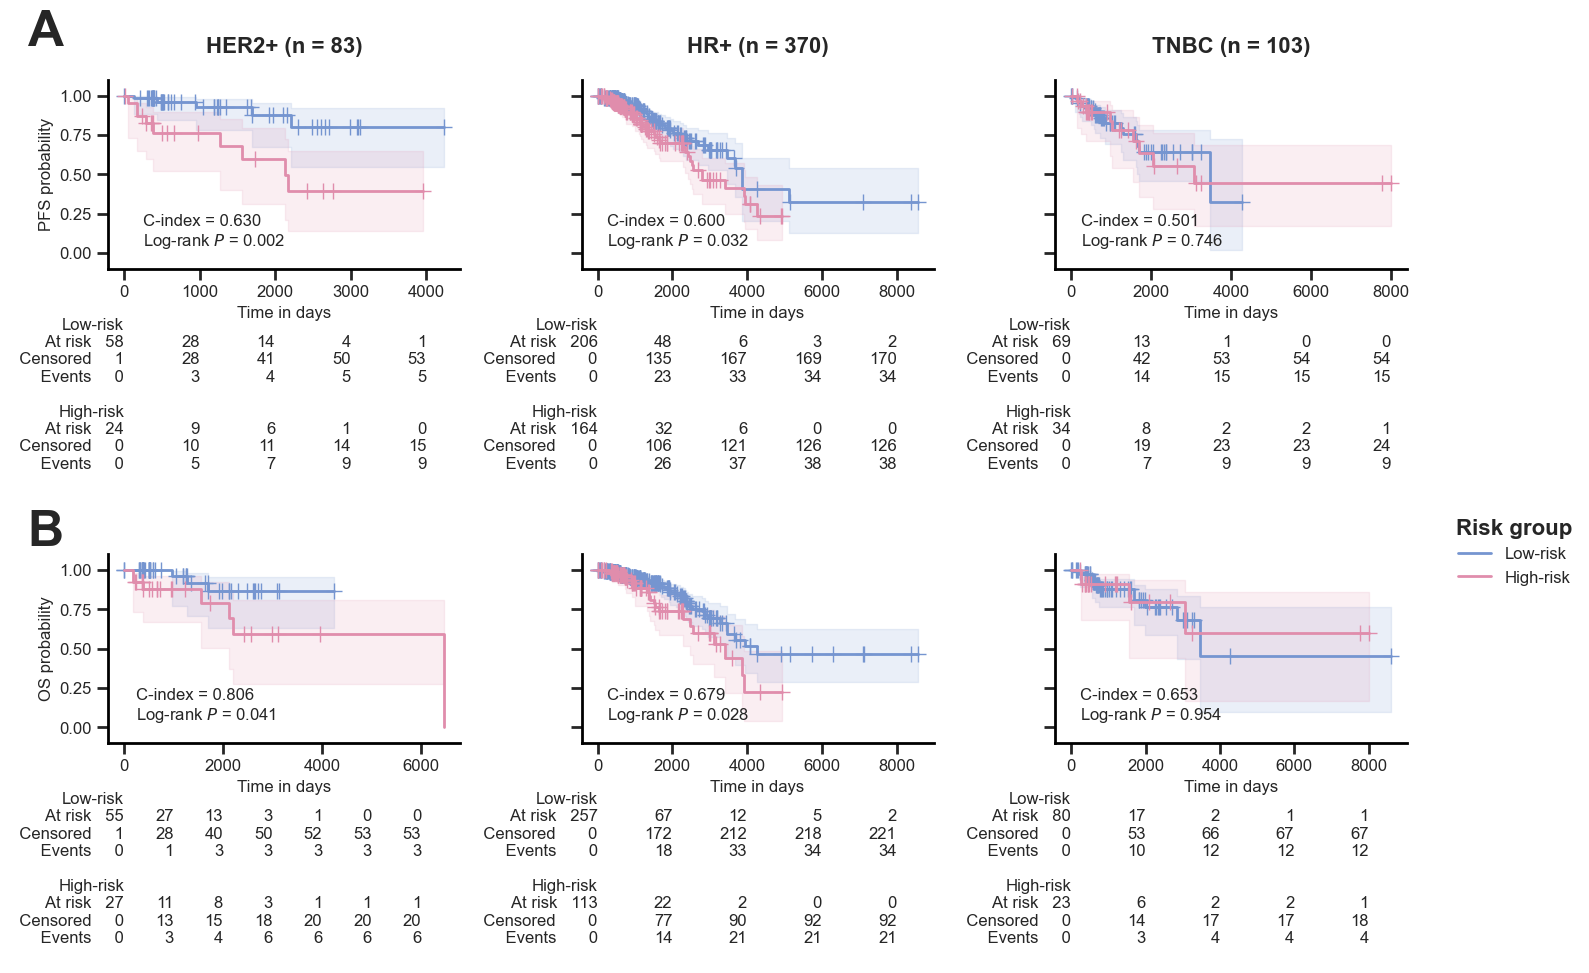

In [4]:
# Load combined for plotting
data_surv = pd.read_csv(final_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import concordance_index

def normalize(x, q=0.1):
    qq = np.quantile(x, q=[q, 1 - q])
    xx = (x - qq[0]) / (qq[1] - qq[0])
    xx[xx < 0] = 0
    xx[xx > 1] = 1
    return xx

surv_grps = ["Low-risk", "High-risk"]
group_th = 0.5
norm_qq = 0.10
subtypes = np.unique(data_surv.Subtype)

fig_data5, fig_stat5 = {}, {}
for surv in ["os", "pfs"]:
    km_data = data_surv[["Subtype", f"risk_score_{surv}", surv, f"{surv}_time"]].copy()
    km_data["risk_score"] = normalize(km_data[f"risk_score_{surv}"], q=norm_qq)
    for sb in subtypes:
        km_grp = km_data[km_data.Subtype == sb].copy()
        km_grp["group"] = km_grp["risk_score"].apply(lambda x: surv_grps[int(x >= group_th)])
        km_grp = km_grp.groupby("group", observed=False).apply(lambda df: df)

        fig_data5[f"{surv}-{sb}"] = {
            grp: KaplanMeierFitter().fit(
                durations=km_grp.loc[grp, f"{surv}_time"],
                event_observed=km_grp.loc[grp, surv],
                label=grp
            )
            for grp in surv_grps
        }

        fig_stat5[f"{surv}-{sb}"] = {
            "Cidx": concordance_index(
                event_times=km_data.loc[km_data.Subtype == sb, f"{surv}_time"],
                event_observed=km_data.loc[km_data.Subtype == sb, surv],
                predicted_scores=-km_data.loc[km_data.Subtype == sb, "risk_score"]
            ),
            "pval": logrank_test(
                durations_A=km_grp.loc[surv_grps[0], f"{surv}_time"],
                event_observed_A=km_grp.loc[surv_grps[0], surv],
                durations_B=km_grp.loc[surv_grps[1], f"{surv}_time"],
                event_observed_B=km_grp.loc[surv_grps[1], surv]
            ).p_value
        }

import matplotlib.pyplot as plt

#%% make fig 5.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors     = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
              "#FFC72C", "#708090", "#A9A9A9", "#000000"]
colors     = colors[:2][::-1]

fontdict   = {"label": {"size": 12, "weight": "regular"}, 
              "sbttl": {"size": 14, "weight": "bold"}, 
              "title": {"size": 16, "weight": "bold"}, 
              "super": {"size": 20, "weight": "bold"}, 
              "panel": {"size": 36, "weight": "bold"}}

lineprop   = {"ls": "-", "lw": 2}

fig_llocs5 = [0.96, 0.46]

fig5, ax5 = plt.subplots(figsize = (16, 10), nrows = 2, ncols = 3, sharey = True)
# ax5 = dict(zip([["A1", "A2", "A3"], ["B1", "B2", "B3"]], ax5))

for i, (surv, lbl) in enumerate(zip(["pfs", "os"], ["A", "B"])):
    for j, sb in enumerate(subtypes):
        dat, stat = fig_data5[f"{surv}-{sb}"], pd.Series(fig_stat5[f"{surv}-{sb}"])
        ax = ax5[i, j]
        for k, (grp, mdl) in enumerate(dat.items()):
            ax = mdl.plot(show_censors = True, ci_show = True, color = colors[k], 
                          ci_alpha = 0.15, ax = ax, **lineprop)
        ax.text(x = 250, y = 0.05, 
                s = f"C-index = {stat.Cidx:0.3f}\nLog-rank $P$ = {stat.pval:0.3f}", 
                **fontdict["label"]);
        add_at_risk_counts(*dat.values(), labels = list(dat.keys()), 
                           rows_to_show = None, ax = ax, **fontdict["label"]);
        sns.despine(ax = ax, offset = 0, trim = False);

        ax.set_ylim([-0.1, 1.1]);
        ax.tick_params(axis = "both", labelsize = fontdict["label"]["size"]);
        if (i, j) == (1, 2):
            ax.legend(loc = (1.12, 0.8), title = "Risk group", prop = fontdict["label"], 
                      title_fontproperties = fontdict["title"])
        else:
            ax.legend([ ], [ ]);

        ax.set_xlabel("Time in days", y = 0.025, **fontdict["label"]);
        if j == 0:
            ax.set_ylabel(f"{surv.upper()} probability", x = 0.025, **fontdict["label"]);
        
        if i == 0:
            ax.set_title(f"{sb} (n = {data_surv.Subtype.eq(sb).sum():,})", wrap = True, 
                         y = 1.1, **fontdict["title"]);

    fig5.text(x = 0.02, y = fig_llocs5[i], s = lbl, **fontdict["panel"]);


fig5.tight_layout(h_pad = 2)
plt.show()
